# Ralph CNOT - All Simulators
This notebook contains a recreation of the Ralph CNOT gate from <cite data-cite="ralph2002">(ralph2002)</cite> and demonstrates the application of different simulation objects.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lightworks as lw
from lightworks import State, emulator

# Define backend for all experiments
backend = emulator.Backend("permanent")

The gate is encoded below with the following mode structure: [a0, c0, c1, t0, t1, a1], where a, c & t are the ancillary, control & target modes respectively. This is a heralded gate, which requires measurements to ensure it works correctly. The input should contain 1 photon in either c0 or c1 and 1 photon in either t0 or t1. The output requires this same criteria, so we should also measure 0 photons across modes a0 and a1. This can be included using the herald method.

In [2]:
r = 1 / 3
loss = 0.05
theta = np.arccos(r)
p = np.pi

cnot_circuit = lw.PhotonicCircuit(6)
to_add = [
    (3, p / 2, 0),
    (0, theta, 0),
    (2, theta, p),
    (4, theta, 0),
    (3, p / 2, 0),
]

for m, t, p in to_add:
    cnot_circuit.bs(m, loss=loss, reflectivity=0.5)
    cnot_circuit.ps(m + 1, t)
    cnot_circuit.bs(m, loss=loss, reflectivity=0.5)
    cnot_circuit.ps(m + 1, p)
    if m in [3, 4, 3]:
        cnot_circuit.barrier()

# Then add required heralds
cnot_circuit.herald(0, 0, 0)
cnot_circuit.herald(0, 5, 5)

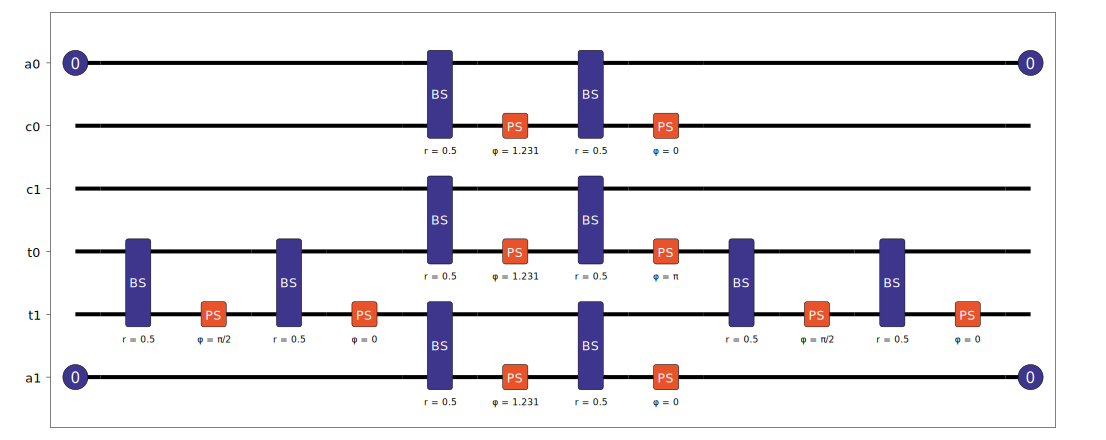

In [3]:
cnot_circuit.display(mode_labels=["a0", "c0", "c1", "t0", "t1", "a1"])

## Simulator
First use simulator to directly calculate the probability amplitudes. Below, the outputs are not specified so the simulator automatically works out all possible values.

In [4]:
states = [
    State([1, 0, 1, 0]),
    State([1, 0, 0, 1]),
    State([0, 1, 1, 0]),
    State([0, 1, 0, 1]),
]

sim = lw.Simulator(cnot_circuit, states)

results = backend.run(sim)

It can be seen that the result is a superposition of many different outputs, the majority of which are not valid according to the usual post-selection rules which would be applied.

In [5]:
results.display_as_dataframe()

,"|2,0,0,0>","|1,1,0,0>","|0,2,0,0>","|1,0,1,0>","|0,1,1,0>","|0,0,2,0>","|1,0,0,1>","|0,1,0,1>","|0,0,1,1>","|0,0,0,2>"
"|1,0,1,0>",0.0+0.0j,-0.257890-0.123166j,0.000000+0.000000j,0.255975-0.090501j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
"|1,0,0,1>",0.0+0.0j,0.257890+0.123166j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.255975-0.090501j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
"|0,1,1,0>",0.0+0.0j,0.000000+0.000000j,0.364711+0.174183j,0.000000+0.000000j,0.000000+0.000000j,-0.157200+0.329152j,0.000000+0.000000j,-0.255975+0.090501j,0.111157-0.232745j,0.000000+0.000000j
"|0,1,0,1>",0.0+0.0j,0.000000+0.000000j,-0.364711-0.174183j,0.000000+0.000000j,-0.255975+0.090501j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.111157+0.232745j,0.157200-0.329152j


Alternatively we can specify the outputs which we know to be valid, and we then get the expected transitions between two qubit states.

In [6]:
sim.outputs = states

results = backend.run(sim)

results.display_as_dataframe(conv_to_probability=True)

,"|1,0,1,0>","|1,0,0,1>","|0,1,1,0>","|0,1,0,1>"
"|1,0,1,0>",0.073713,0.000000,0.000000,0.000000
"|1,0,0,1>",0.000000,0.073713,0.000000,0.000000
"|0,1,1,0>",0.000000,0.000000,0.000000,0.073713
"|0,1,0,1>",0.000000,0.000000,0.073713,0.000000


## Sampler
The sampler can be used to sample from all possible outputs for one of the possible input states.

In [7]:
sampler = lw.Sampler(cnot_circuit, State([0, 1, 1, 0]), 10000)

results = backend.run(sampler)

The output distribution can then be plotted to view the number of times each state is measured.

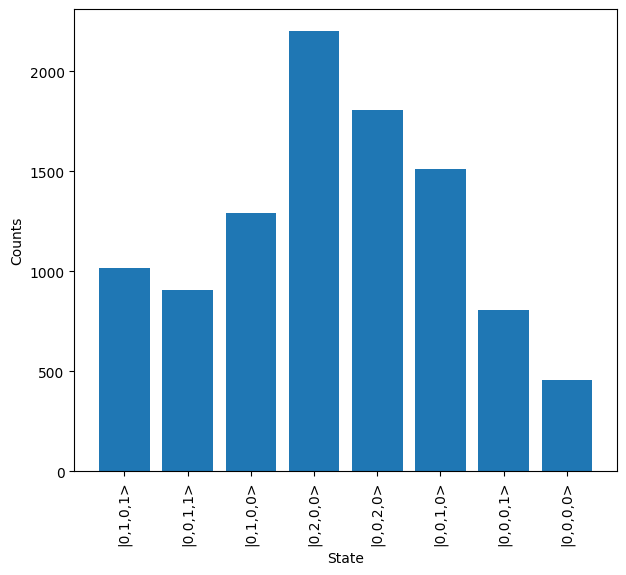

In [8]:
results.plot()

It is also possible to introduce an imperfect source and detectors, which introduces a significant number of additional possible states.

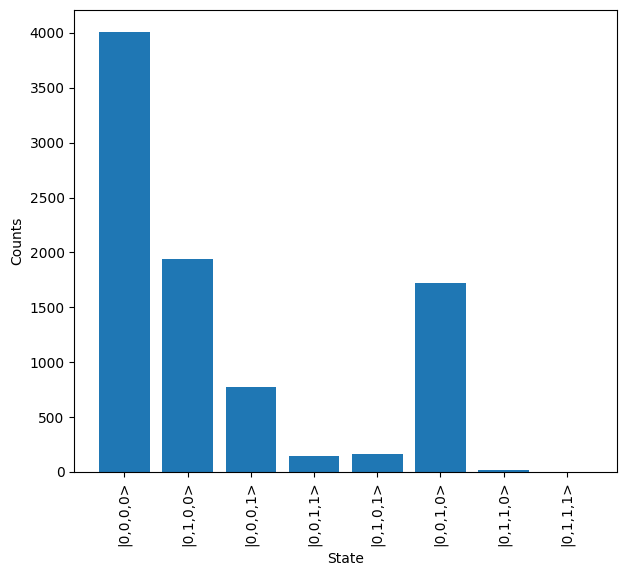

In [9]:
source = emulator.Source(purity=0.98, brightness=0.5, indistinguishability=0.94)
detector = emulator.Detector(efficiency=0.9, p_dark=1e-5, photon_counting=False)

sampler = lw.Sampler(
    cnot_circuit,
    State([0, 1, 1, 0]),
    10000,
    source=source,
    detector=detector,
    sampling_mode="input",
)

results = backend.run(sampler)

results.plot()

However, we can clean this up by post-selection on the number of photons across the modes. We don't need to re-create the sampler object and find the probability distribution for this, and instead just pass the post-selection function to the sample_N_inputs function.

In [10]:
sampler.post_selection = lambda s: s[0] + s[1] == 1 and s[2] + s[3] == 1

results = backend.run(sampler)

It can be seen below that this significantly cleans up the output states measured, and with the exception of a few erroneous states we see the expected output of |0,1,0,1>

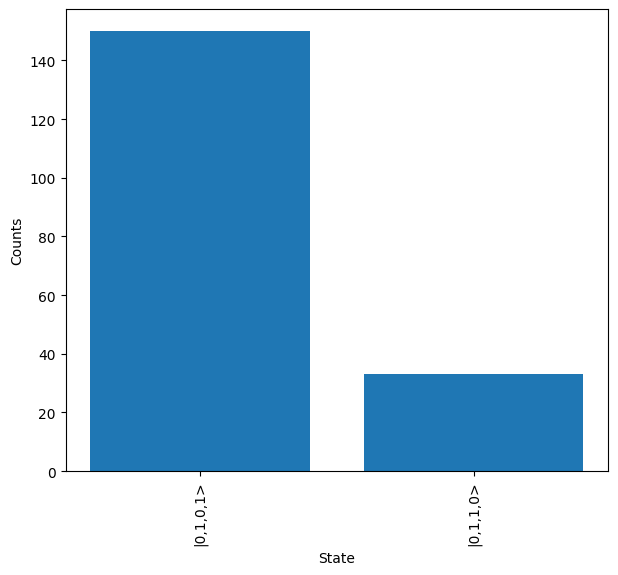

In [11]:
results.plot()

## Analyzer
The Analyzer will determine all possible outputs under a given set of conditions (such as post-selection and heralding) and return the probability of each. 

This is created by specifying the circuit to analyze, each possible input for the circuit and the expected transformations between states. This is used to calculate an error rate. It is also possible to determine an average performance, which is the defined as the average probability that a valid output is produced across all inputs.

Post-selection is also included so only one photon is measured across modes 1/2 and 3/4. 

In [12]:
inputs = {
    "00": State([1, 0, 1, 0]),
    "01": State([1, 0, 0, 1]),
    "10": State([0, 1, 1, 0]),
    "11": State([0, 1, 0, 1]),
}
states = list(inputs.values())

expected = {
    inputs["00"]: inputs["00"],
    inputs["01"]: inputs["01"],
    inputs["10"]: inputs["11"],
    inputs["11"]: inputs["10"],
}

analyzer = lw.Analyzer(cnot_circuit, states, expected)
analyzer.post_selection = lambda s: s[0] + s[1] == 1 and s[2] + s[3] == 1

# analyzer = emulator.Analyzer(cnot_circuit)
results = backend.run(analyzer)

print(f"Performance = {round(results.performance * 100, 3)} %")
print(f"Error rate: {round(results.error_rate * 100, 3)} %")

Performance = 7.371 %
Error rate: 0.0 %


These results can then also be plotted as a heatmap to view the transformation.

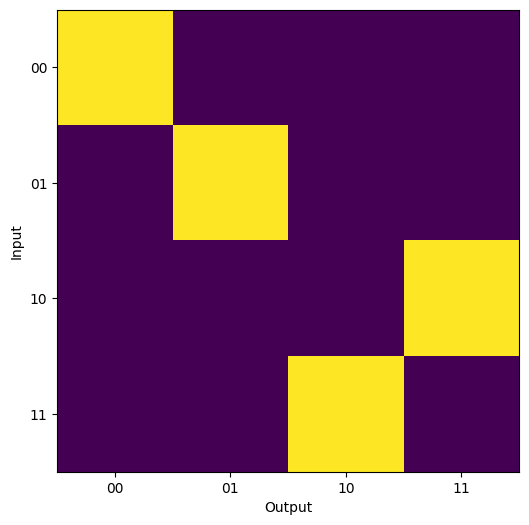

In [13]:
plot_array = np.zeros((len(inputs), len(inputs)))
for i, istate in enumerate(inputs.values()):
    for j, ostate in enumerate(inputs.values()):
        plot_array[i, j] = results[istate, ostate]

in_labels = list(inputs.keys())
out_labels = in_labels

plt.figure(figsize=(7, 6))
plt.imshow(plot_array)
plt.xticks(range(len(out_labels)), labels=out_labels)
plt.yticks(range(len(in_labels)), labels=in_labels)
plt.xlabel("Output")
plt.ylabel("Input")
plt.show()